In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load dataset
data = pd.read_csv("synthetic_health_data.csv")

# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Impute missing values for numeric columns
imputer = SimpleImputer(strategy="mean")
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# For categorical columns, you can use a different imputation strategy if needed
# (e.g., most frequent), but here we're assuming no missing categorical values.

# Verify no missing values remain
print(data.isnull().sum())


age                 0
gender              0
weight_kg           0
height_cm           0
heart_rate          0
calories            0
activity_level      0
smoking_status      0
alcohol_intake    337
risk                0
dtype: int64


In [3]:
# Separate features and target variable
X = data.drop(columns=['risk'])
y = data['risk']

# Encode categorical features
label_encoders = {}
for column in ['gender', 'activity_level', 'smoking_status', 'alcohol_intake']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Scale numerical features
scaler = StandardScaler()
X[['age', 'weight_kg', 'height_cm', 'heart_rate', 'calories']] = scaler.fit_transform(
    X[['age', 'weight_kg', 'height_cm', 'heart_rate', 'calories']]
)

# Encode target variable (health risk)
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

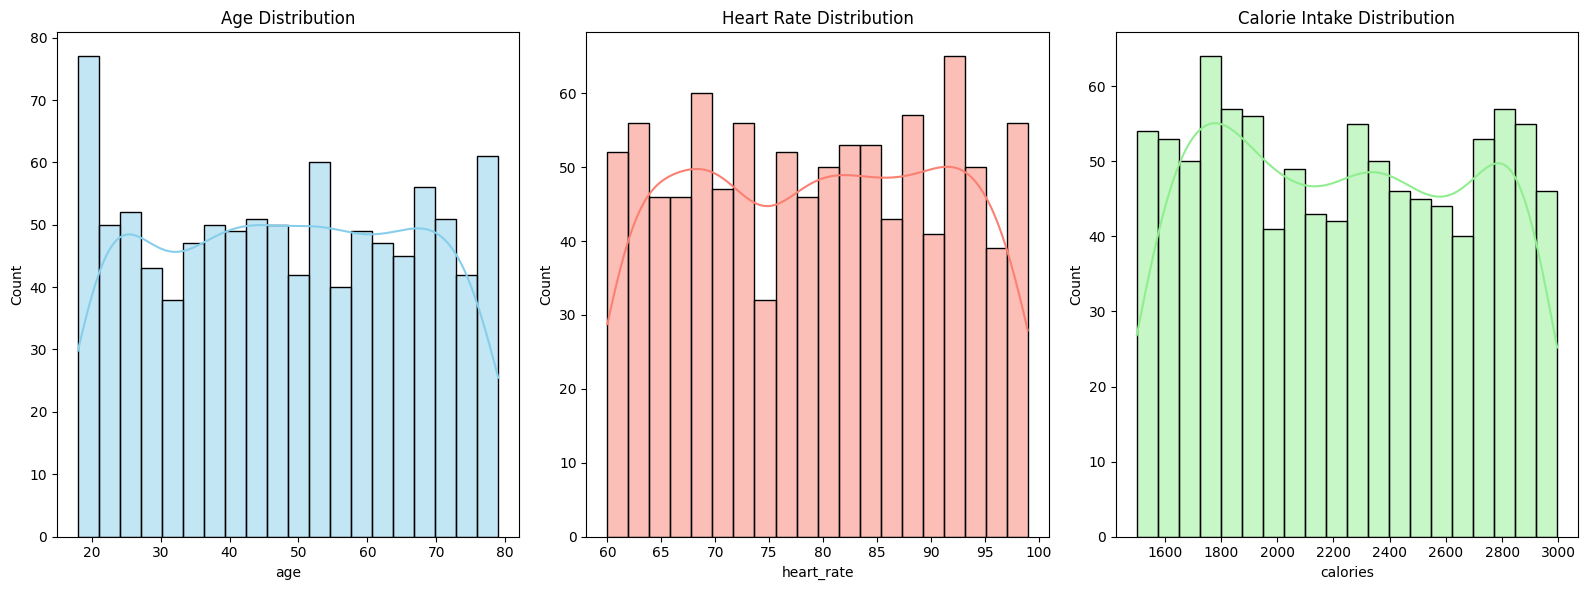

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(16, 6))

# Age distribution
plt.subplot(1, 3, 1)
sns.histplot(data['age'], kde=True, bins=20, color='skyblue')
plt.title("Age Distribution")

# Heart rate distribution
plt.subplot(1, 3, 2)
sns.histplot(data['heart_rate'], kde=True, bins=20, color='salmon')
plt.title("Heart Rate Distribution")

# Calorie intake distribution
plt.subplot(1, 3, 3)
sns.histplot(data['calories'], kde=True, bins=20, color='lightgreen')
plt.title("Calorie Intake Distribution")

plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9068\508695109.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk', data=data, palette='viridis')


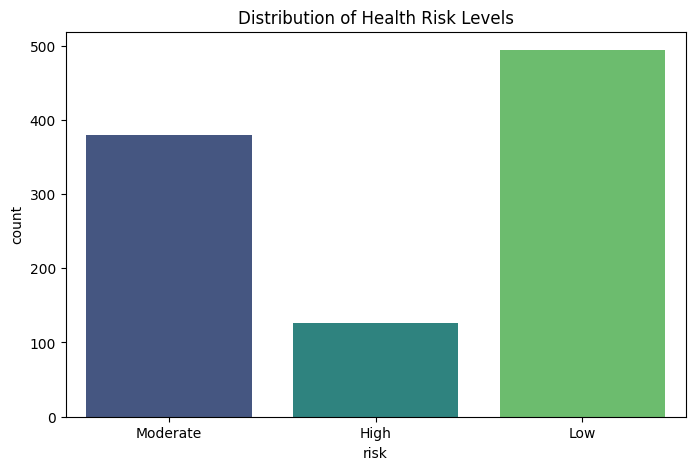

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9068\508695109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='risk', y='age', data=data, palette='pastel')


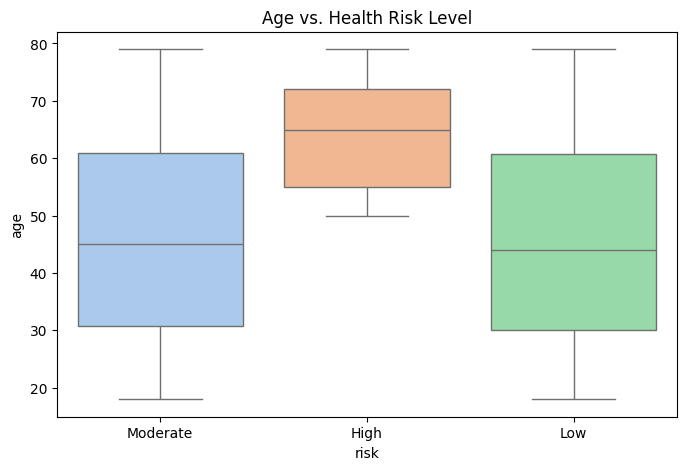

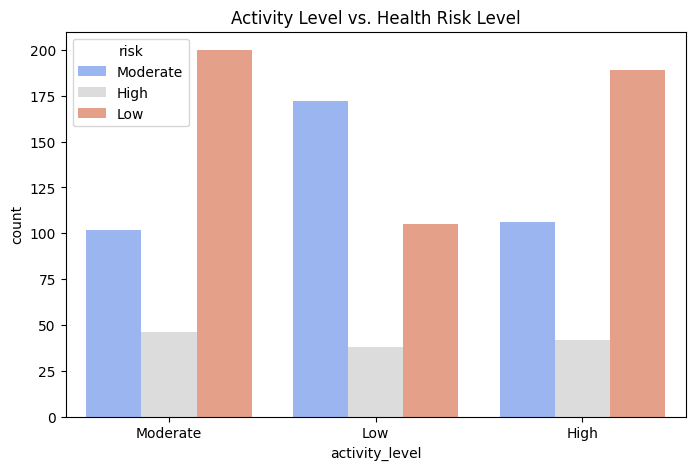

In [5]:
# Risk level distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='risk', data=data, palette='viridis')
plt.title("Distribution of Health Risk Levels")
plt.show()

# Age vs. Risk level
plt.figure(figsize=(8, 5))
sns.boxplot(x='risk', y='age', data=data, palette='pastel')
plt.title("Age vs. Health Risk Level")
plt.show()

# Activity level vs. Risk level
plt.figure(figsize=(8, 5))
sns.countplot(x='activity_level', hue='risk', data=data, palette='coolwarm')
plt.title("Activity Level vs. Health Risk Level")
plt.show()


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

Model Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.99      1.00      1.00       101
           2       1.00      0.99      0.99        77

    accuracy                           0.99       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      0.99      0.99       200



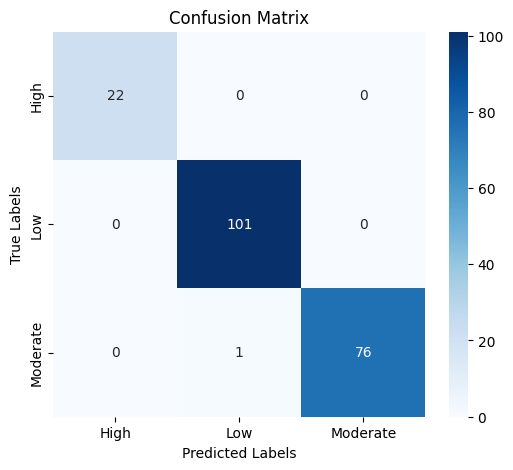

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9068\1257062859.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


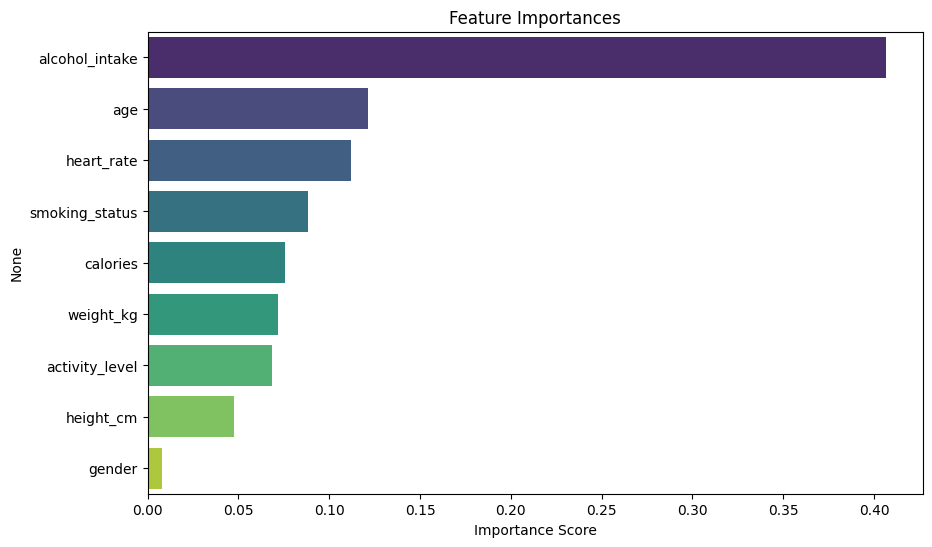

In [8]:
# Feature Importance
importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.xlabel("Importance Score")
plt.show()


In [9]:
import joblib

# Save label encoders and scaler after preprocessing and training
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Saved encoders and scaler.")


Saved encoders and scaler.


In [10]:
import joblib

# Assuming 'model' is the trained RandomForest model
joblib.dump(model, "health_risk_model.pkl")


['health_risk_model.pkl']

In [ ]:
def preprocess_input(data):
    for col, le in label_encoders.items():
        try:
            # Check if the value is within the known categories
            if data[col] not in le.classes_:
                st.error(f"Error: Value '{data[col]}' for '{col}' not in training data categories.")
                return None
            data[col] = le.transform([data[col]])[0]
        except ValueError as e:
            st.error(f"Error in encoding {col}: {e}")
            return None
    
    # Scale numeric features
    numeric_features = ['age', 'weight_kg', 'height_cm', 'heart_rate', 'calories']
    data[numeric_features] = scaler.transform([data[numeric_features]])
    
    return pd.DataFrame([data])


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import joblib


# Load updated dataset
data = pd.read_csv("updated_synthetic_health_data.csv")

# Prepare data for training
X = data.drop(columns=['risk'])
y = data['risk']

# Label encode categorical features
categorical_features = ['gender', 'activity_level', 'smoking_status', 'alcohol_intake']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Label encode the target variable
risk_le = LabelEncoder()
y = risk_le.fit_transform(y)
label_encoders['risk'] = risk_le

# Scale numeric features
scaler = StandardScaler()
numeric_features = ['age', 'weight_kg', 'height_cm', 'heart_rate', 'calories']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the updated model, encoders, and scaler
joblib.dump(model, "health_risk_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model retrained and saved!")


Model retrained and saved!
